### Importing Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import warnings; warnings.simplefilter('ignore')

### Loading Datasets

In [3]:
apps = pd.read_csv('C:/Users/HP/Downloads/job-recommendation/apps/apps.tsv', delimiter='\t',encoding='utf-8')
user_history = pd.read_csv('C:/Users/HP/Downloads/job-recommendation/user_history/user_history.tsv', delimiter='\t',encoding='utf-8')
jobs = pd.read_csv('C:/Users/HP/Downloads/job-recommendation/jobs/jobs.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)
users = pd.read_csv('C:/Users/HP/Downloads/job-recommendation/users/users.tsv' ,delimiter='\t',encoding='utf-8')
test_users = pd.read_csv('C:/Users/HP/Downloads/job-recommendation/test_users/test_users.tsv', delimiter='\t',encoding='utf-8')

b'Skipping line 122433: expected 11 fields, saw 12\n'
b'Skipping line 602576: expected 11 fields, saw 12\n'
b'Skipping line 990950: expected 11 fields, saw 12\n'


# Data Preprocessing 

### app.tsv

In [77]:
apps.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [78]:
apps.columns

Index(['UserID', 'WindowID', 'Split', 'ApplicationDate', 'JobID'], dtype='object')

In [79]:
apps.shape

(1603111, 5)

In [80]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603111 entries, 0 to 1603110
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   UserID           1603111 non-null  int64 
 1   WindowID         1603111 non-null  int64 
 2   Split            1603111 non-null  object
 3   ApplicationDate  1603111 non-null  object
 4   JobID            1603111 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 61.2+ MB


In [81]:
apps.describe()

,UserID,WindowID,JobID
count,1.603111e+06,1.603111e+06,1.603111e+06
mean,7.627023e+05,3.643567e+00,5.652615e+05
std,4.225649e+05,2.029082e+00,3.239136e+05
min,7.000000e+00,1.000000e+00,1.000000e+00
25%,3.936690e+05,2.000000e+00,2.805265e+05
50%,7.841790e+05,4.000000e+00,5.678070e+05
75%,1.126113e+06,5.000000e+00,8.498670e+05
max,1.472095e+06,7.000000e+00,1.116313e+06


In [82]:
apps.isnull().sum()

UserID             0
WindowID           0
Split              0
ApplicationDate    0
JobID              0
dtype: int64

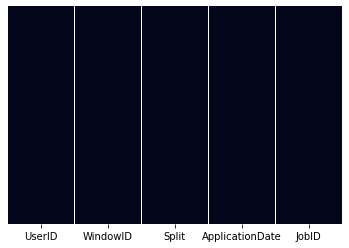

In [83]:
sns.heatmap(apps.isnull(),yticklabels=False,cbar=False)

### user_history.tsv

In [84]:
user_history.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [85]:
user_history.columns

Index(['UserID', 'WindowID', 'Split', 'Sequence', 'JobTitle'], dtype='object')

In [86]:
user_history.shape

(1753901, 5)

In [87]:
user_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753901 entries, 0 to 1753900
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   UserID    int64 
 1   WindowID  int64 
 2   Split     object
 3   Sequence  int64 
 4   JobTitle  object
dtypes: int64(3), object(2)
memory usage: 66.9+ MB


In [88]:
user_history.describe()

,UserID,WindowID,Sequence
count,1.753901e+06,1.753901e+06,1.753901e+06
mean,7.553150e+05,3.698127e+00,3.367196e+00
std,4.288041e+05,2.038981e+00,2.180562e+00
min,7.000000e+00,1.000000e+00,1.000000e+00
25%,3.732070e+05,2.000000e+00,2.000000e+00
50%,7.703950e+05,4.000000e+00,3.000000e+00
75%,1.129366e+06,5.000000e+00,5.000000e+00
max,1.472095e+06,7.000000e+00,1.200000e+02


In [89]:
user_history.isnull().sum()

UserID           0
WindowID         0
Split            0
Sequence         0
JobTitle    100635
dtype: int64

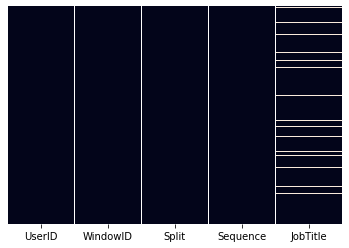

In [90]:
sns.heatmap(user_history.isnull(),yticklabels=False,cbar=False)

### jobs.tsv

In [91]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


In [92]:
jobs.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [93]:
jobs.shape

(1091923, 11)

In [94]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091923 entries, 0 to 1091922
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   JobID         1091923 non-null  int64 
 1   WindowID      1091923 non-null  int64 
 2   Title         1091916 non-null  object
 3   Description   1091913 non-null  object
 4   Requirements  1050521 non-null  object
 5   City          1091921 non-null  object
 6   State         1091922 non-null  object
 7   Country       1091920 non-null  object
 8   Zip5          685724 non-null   object
 9   StartDate     1091923 non-null  object
 10  EndDate       1091914 non-null  object
dtypes: int64(2), object(9)
memory usage: 91.6+ MB


In [95]:
jobs.describe()

,JobID,WindowID
count,1.091923e+06,1.091923e+06
mean,5.581637e+05,3.460999e+00
std,3.222901e+05,2.062479e+00
min,1.000000e+00,1.000000e+00
25%,2.791075e+05,1.000000e+00
50%,5.583070e+05,3.000000e+00
75%,8.374075e+05,5.000000e+00
max,1.116314e+06,7.000000e+00


In [96]:
jobs.isnull().sum()

JobID                0
WindowID             0
Title                7
Description         10
Requirements     41402
City                 2
State                1
Country              3
Zip5            406199
StartDate            0
EndDate              9
dtype: int64

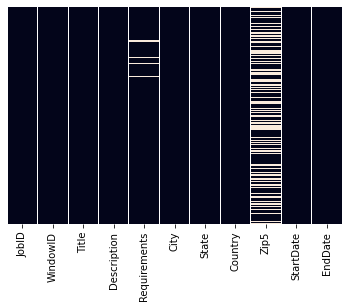

In [97]:
sns.heatmap(jobs.isnull(),yticklabels=False,cbar=False)

### users.tsv

In [98]:
users.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [99]:
users.columns

Index(['UserID', 'WindowID', 'Split', 'City', 'State', 'Country', 'ZipCode',
       'DegreeType', 'Major', 'GraduationDate', 'WorkHistoryCount',
       'TotalYearsExperience', 'CurrentlyEmployed', 'ManagedOthers',
       'ManagedHowMany'],
      dtype='object')

In [100]:
users.shape

(389708, 15)

In [101]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389708 entries, 0 to 389707
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   UserID                389708 non-null  int64  
 1   WindowID              389708 non-null  int64  
 2   Split                 389708 non-null  object 
 3   City                  389708 non-null  object 
 4   State                 389218 non-null  object 
 5   Country               389708 non-null  object 
 6   ZipCode               387974 non-null  object 
 7   DegreeType            389708 non-null  object 
 8   Major                 292468 non-null  object 
 9   GraduationDate        269477 non-null  object 
 10  WorkHistoryCount      389708 non-null  int64  
 11  TotalYearsExperience  375528 non-null  float64
 12  CurrentlyEmployed     347632 non-null  object 
 13  ManagedOthers         389708 non-null  object 
 14  ManagedHowMany        389708 non-null  int64  
dtype

In [102]:
users.describe()

,UserID,WindowID,WorkHistoryCount,TotalYearsExperience,ManagedHowMany
count,3.897080e+05,389708.000000,389708.000000,375528.000000,3.897080e+05
mean,7.403046e+05,3.703232,4.500239,12.325898,2.952590e+01
std,4.247300e+05,2.039483,2.356366,8.726533,1.352215e+04
min,7.000000e+00,1.000000,0.000000,0.000000,0.000000e+00
25%,3.700468e+05,2.000000,3.000000,6.000000,0.000000e+00
50%,7.449385e+05,4.000000,4.000000,11.000000,0.000000e+00
75%,1.107553e+06,5.000000,6.000000,16.000000,2.000000e+00
max,1.472095e+06,7.000000,120.000000,112.000000,8.441226e+06


In [103]:
users.isnull().sum()

UserID                       0
WindowID                     0
Split                        0
City                         0
State                      490
Country                      0
ZipCode                   1734
DegreeType                   0
Major                    97240
GraduationDate          120231
WorkHistoryCount             0
TotalYearsExperience     14180
CurrentlyEmployed        42076
ManagedOthers                0
ManagedHowMany               0
dtype: int64

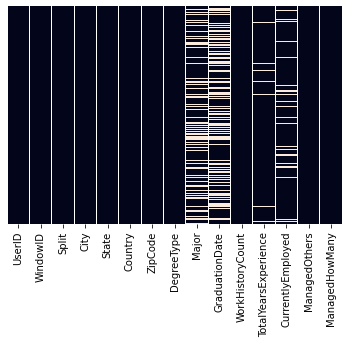

In [104]:
sns.heatmap(users.isnull(),yticklabels=False,cbar=False)

### test_users.tsv

In [105]:
test_users.head()

,UserID,WindowID
0,767,1
1,769,1
2,861,1
3,1006,1
4,1192,1


In [106]:
test_users.columns

Index(['UserID', 'WindowID'], dtype='object')

In [107]:
test_users.shape

(22838, 2)

In [108]:
test_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22838 entries, 0 to 22837
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   UserID    22838 non-null  int64
 1   WindowID  22838 non-null  int64
dtypes: int64(2)
memory usage: 357.0 KB


In [109]:
test_users.describe()

,UserID,WindowID
count,2.283800e+04,22838.000000
mean,7.532056e+05,3.345477
std,4.212947e+05,1.924259
min,1.300000e+01,1.000000
25%,3.862738e+05,2.000000
50%,7.686175e+05,3.000000
75%,1.117234e+06,5.000000
max,1.472073e+06,7.000000


In [110]:
test_users.isnull().sum()

UserID      0
WindowID    0
dtype: int64

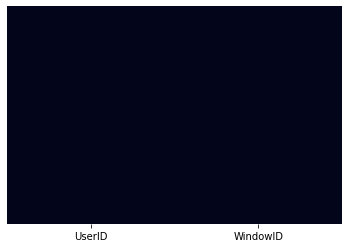

In [111]:
sns.heatmap(test_users.isnull(),yticklabels=False,cbar=False)

# Exploratory Data Analysis (EDA) 

### Split training and testing data based on column split

In [112]:
apps_training = apps.loc[apps['Split'] == 'Train']

In [113]:
apps_training.shape

(1417514, 5)

In [114]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [115]:
apps_testing = apps.loc[apps['Split'] == 'Test']

In [116]:
apps_testing.shape

(185597, 5)

In [117]:
apps_testing.head()

,UserID,WindowID,Split,ApplicationDate,JobID
126,767,1,Test,2012-04-01 14:37:20.023,85377
127,769,1,Test,2012-04-16 22:36:52.48,853328
128,769,1,Test,2012-04-09 18:59:28.193,86106
129,769,1,Test,2012-04-09 18:59:31.127,327571
130,769,1,Test,2012-04-08 21:29:11.993,119161


In [118]:
user_history_training = user_history.loc[user_history['Split'] =='Train']

In [119]:
user_history_training.shape

(1652513, 5)

In [120]:
user_history_training.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [121]:
user_history_testing = user_history.loc[user_history['Split'] =='Test']

In [122]:
user_history_testing.shape

(101388, 5)

In [123]:
user_history_testing.head()

,UserID,WindowID,Split,Sequence,JobTitle
144,767,1,Test,1,Claims Adjuster
145,767,1,Test,2,Professional Baseball Player
146,767,1,Test,3,Professional Baseball Player
147,767,1,Test,4,Professional Baseball Player
148,767,1,Test,5,Professional Baseball Player


In [124]:
users_training = users.loc[users['Split']=='Train']

In [125]:
users_training.shape

(366870, 15)

In [126]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [127]:
users_testing = users.loc[users['Split']=='Test']

In [128]:
users_testing.shape

(22838, 15)

In [129]:
users_testing.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
31,767,1,Test,Murrieta,CA,US,92562,Bachelor's,University Studies/Business,2008-05-01 00:00:00,5,16.0,No,No,0
32,769,1,Test,Roselle,IL,US,60172,Bachelor's,Radio-Television,2011-05-01 00:00:00,5,5.0,Yes,No,0
33,861,1,Test,Morris,IL,US,60450,High School,General Studies,1989-05-01 00:00:00,7,21.0,NaN,No,0
38,1006,1,Test,West Chester,PA,US,19382,High School,Not Applicable,2008-06-01 00:00:00,3,6.0,Yes,No,0
44,1192,1,Test,Cincinnati,OH,US,45255,Bachelor's,Marketing,NaN,5,6.0,Yes,No,0


### List down all training data records

In [130]:
apps_training.head()

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04 15:56:23.537,169528
1,47,1,Train,2012-04-06 01:03:00.003,284009
2,47,1,Train,2012-04-05 02:40:27.753,2121
3,47,1,Train,2012-04-05 02:37:02.673,848187
4,47,1,Train,2012-04-05 22:44:06.653,733748


In [131]:
user_history_training.head()

,UserID,WindowID,Split,Sequence,JobTitle
0,47,1,Train,1,National Space Communication Programs-Special ...
1,47,1,Train,2,Detention Officer
2,47,1,Train,3,"Passenger Screener, TSA"
3,72,1,Train,1,"Lecturer, Department of Anthropology"
4,72,1,Train,2,Student Assistant


In [132]:
users_training.head(5).transpose()

,0,1,2,3,4
UserID,47,72,80,98,123
WindowID,1,1,1,1,1
Split,Train,Train,Train,Train,Train
City,Paramount,La Mesa,Williamstown,Astoria,Baton Rouge
State,CA,CA,NJ,NY,LA
Country,US,US,US,US,US
ZipCode,90723,91941,08094,11105,70808
DegreeType,High School,Master's,High School,Master's,Bachelor's
Major,NaN,Anthropology,Not Applicable,Journalism,Agricultural Business
GraduationDate,1999-06-01 00:00:00,2011-01-01 00:00:00,1985-06-01 00:00:00,2007-05-01 00:00:00,2011-05-01 00:00:00


In [133]:
jobs.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US,20531,2012-03-07 13:17:01.643,2012-04-06 23:59:59
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US,28217,2012-03-21 02:03:44.137,2012-04-20 23:59:59
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US,32792,2012-03-02 16:36:55.447,2012-04-01 23:59:59
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:10.077,2012-04-02 23:59:59
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US,NaN,2012-03-03 09:01:11.88,2012-04-02 23:59:59


### EDA for job openings based on their location information

In [134]:
jobs.groupby(['City','State','Country']).size().reset_index(name='Locationwise')

,City,State,Country,Locationwise
0,&#60;&#47;b&#62; Brno &#60;b&#62;,,CZ,1
1,&#60;&#47;b&#62; Praha &#60;b&#62;,,CZ,1
2,- Any,,CZ,13
3,29 Palms,CA,US,1
4,<,,HU,1
...,...,...,...,...
15689,puebla,,MX,1
15690,san jose,,BJ,6
15691,san jose,,UA,1
15692,seoul,,KR,2


In [135]:
jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

,Country,Locationwise
59,US,1090462
4,AF,560
19,CZ,193
40,MX,93
52,TR,81


In [136]:
Country_wise_job = jobs.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False)

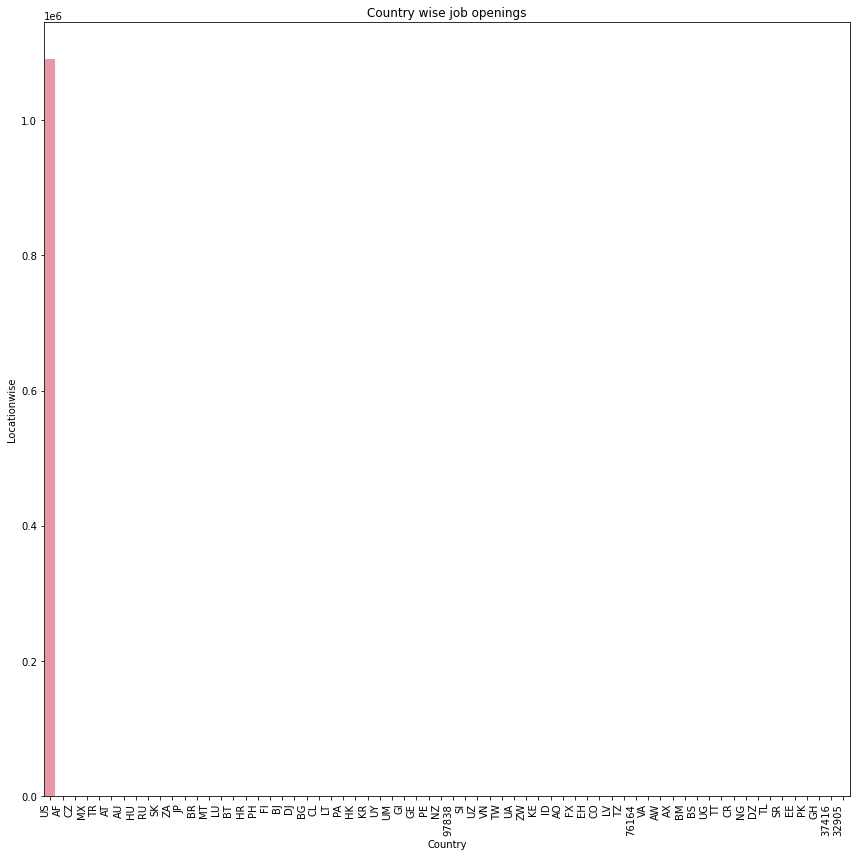

In [137]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Country", y="Locationwise", data=Country_wise_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Country wise job openings')
plt.tight_layout()
plt.show()

In [138]:
jobs_US = jobs.loc[jobs['Country']=='US']

In [139]:
jobs_US[['City','State','Country']]

,City,State,Country
0,Washington,DC,US
1,Charlotte,NC,US
2,Winter Park,FL,US
3,Orlando,FL,US
4,Orlando,FL,US
...,...,...,...
1091918,Amsterdam,NY,US
1091919,Birmingham,AL,US
1091920,Carthage,MS,US
1091921,Warren,MI,US


In [141]:
jobs_US.groupby(['City','State','Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

,City,State,Country,Locationwise
6601,Houston,TX,US,19306
9835,New York,NY,US,18395
2651,Chicago,IL,US,17806
3475,Dallas,TX,US,13139
610,Atlanta,GA,US,12352


In [142]:
State_wise_job_US = jobs_US.groupby(['State']).size().reset_index(name=
                                                                       'Locationwise'
                                                                      ).sort_values('Locationwise',ascending=False)

In [143]:
State_wise_job_US

,State,Locationwise
5,CA,109630
48,TX,98071
10,FL,71024
16,IL,58743
38,NY,53998
42,PA,48999
39,OH,45048
34,NJ,35175
30,NC,34553
11,GA,33453


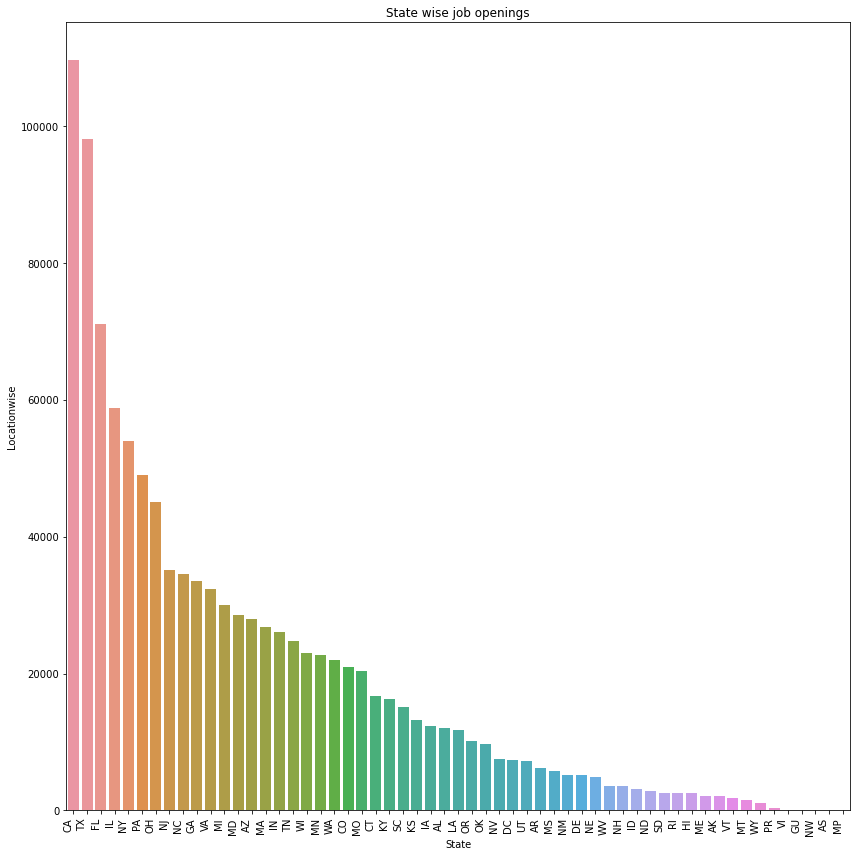

In [144]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise",data=State_wise_job_US)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job openings')
plt.tight_layout()
plt.show()

In [145]:
jobs_US.groupby(['City']).size().reset_index(name='Locationwise').sort_values('Locationwise',ascending=False)

,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
...,...,...
2293,Cuchillo,1
7652,Picabo,1
2290,Crystola,1
2286,Crystal Hill,1


In [146]:
City_wise_location = jobs_US.groupby(['City']).size().reset_index(
    name='Locationwise').sort_values('Locationwise',ascending=False)

In [147]:
City_wise_location_th = City_wise_location.loc[City_wise_location['Locationwise']>=12]

In [148]:
City_wise_location_th

,City,Locationwise
4564,Houston,19323
6809,New York,18402
1782,Chicago,17806
2351,Dallas,13202
408,Atlanta,12365
...,...,...
6838,Newport Coast,12
4655,Ijamsville,12
2510,Denmark,12
9904,University Heights,12


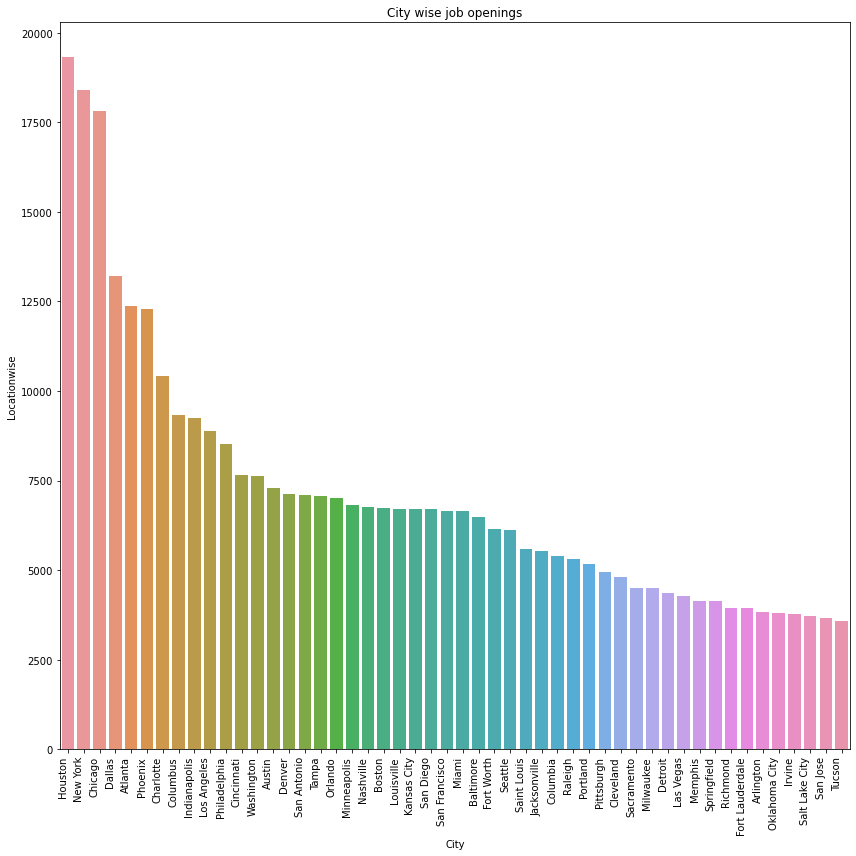

In [149]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise",data=City_wise_location_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('City wise job openings')
plt.tight_layout()
plt.show()

In [150]:
users_training.groupby(['Country']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                                        ascending=False).head()

,Country,Locationwise
105,US,365740
47,IN,236
18,CA,108
81,PH,59
82,PK,59


In [151]:
user_training_US = users_training.loc[users_training['Country']=='US']

In [152]:
user_training_US.shape

(365740, 15)

In [153]:
user_training_US.groupby(['State']).size().reset_index(
    name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

,State,Locationwise_state
11,FL,40381
47,TX,33260
6,CA,31141
17,IL,22557
37,NY,19299
41,PA,16206
12,GA,15003
34,NJ,14887
38,OH,14750
30,NC,13887


In [154]:
user_training_US_state_wise = user_training_US.groupby(['State']).size().reset_index(
    name='Locationwise_state').sort_values('Locationwise_state',ascending=False)

In [155]:
user_training_US_th = user_training_US_state_wise.loc[user_training_US_state_wise['Locationwise_state']>=12]

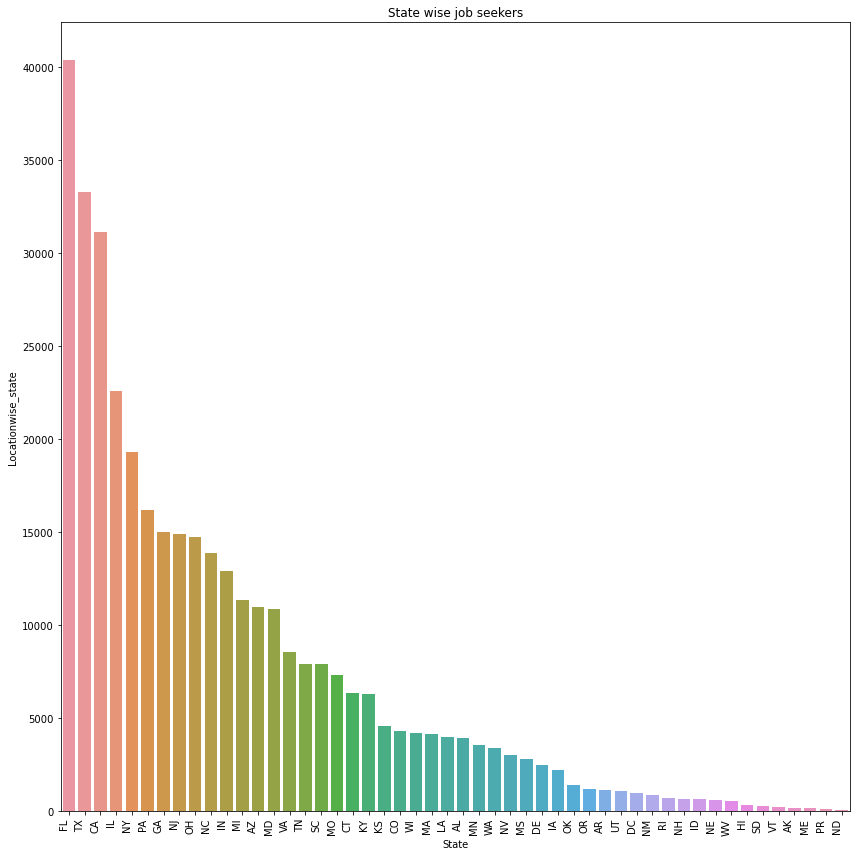

In [156]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="State", y="Locationwise_state",data=user_training_US_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

In [157]:
user_training_US.groupby(['City']).size().reset_index(
    name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

,City,Locationwise_city
1528,Chicago,6964
4066,Houston,5487
4177,Indianapolis,4450
5604,Miami,4359
6965,Philadelphia,4347
...,...,...
3046,Fort Pierre,1
3042,Fort Ogden,1
7369,Rancho Murieta,1
3032,Fort McCoy,1


In [158]:
user_training_US_city_wise = user_training_US.groupby(['City']).size().reset_index(
    name='Locationwise_city').sort_values('Locationwise_city',ascending=False)

In [159]:
user_training_US_City_th = user_training_US_city_wise.loc[user_training_US_city_wise['Locationwise_city']>=12]

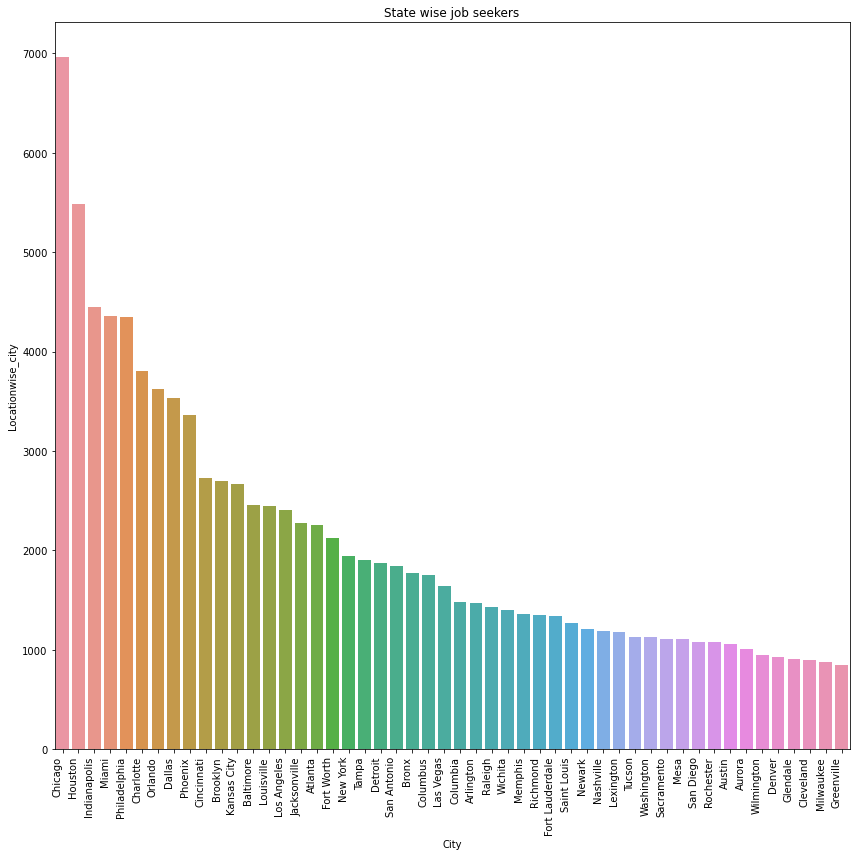

In [160]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="City", y="Locationwise_city",data=user_training_US_City_th.head(50))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('State wise job seekers')
plt.tight_layout()
plt.show()

### revised approach

In [161]:
jobs_US.columns

Index(['JobID', 'WindowID', 'Title', 'Description', 'Requirements', 'City',
       'State', 'Country', 'Zip5', 'StartDate', 'EndDate'],
      dtype='object')

In [162]:
jobs_US.head().transpose()

,0,1,2,3,4
JobID,1,4,7,8,9
WindowID,1,1,1,1,1
Title,Security Engineer/Technical Lead,SAP Business Analyst / WM,P/T HUMAN RESOURCES ASSISTANT,Route Delivery Drivers,Housekeeping
Description,<p>Security Clearance Required:&nbsp; Top Secr...,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,CITY BEVERAGES Come to work for the best in th...,I make sure every part of their day is magica...
Requirements,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...,Please refer to the Job Description to view th...
City,Washington,Charlotte,Winter Park,Orlando,Orlando
State,DC,NC,FL,FL,FL
Country,US,US,US,US,US
Zip5,20531,28217,32792,NaN,NaN
StartDate,2012-03-07 13:17:01.643,2012-03-21 02:03:44.137,2012-03-02 16:36:55.447,2012-03-03 09:01:10.077,2012-03-03 09:01:11.88


In [163]:
jobs_US_base_line = jobs_US.iloc[0:10000,0:8]

In [164]:
jobs_US_base_line.head()

,JobID,WindowID,Title,Description,Requirements,City,State,Country
0,1,1,Security Engineer/Technical Lead,<p>Security Clearance Required:&nbsp; Top Secr...,<p>SKILL SET</p>\r<p>&nbsp;</p>\r<p>Network Se...,Washington,DC,US
1,4,1,SAP Business Analyst / WM,<strong>NO Corp. to Corp resumes&nbsp;are bein...,<p><b>WHAT YOU NEED: </b></p>\r<p>Four year co...,Charlotte,NC,US
2,7,1,P/T HUMAN RESOURCES ASSISTANT,<b> <b> P/T HUMAN RESOURCES ASSISTANT</b> <...,Please refer to the Job Description to view th...,Winter Park,FL,US
3,8,1,Route Delivery Drivers,CITY BEVERAGES Come to work for the best in th...,Please refer to the Job Description to view th...,Orlando,FL,US
4,9,1,Housekeeping,I make sure every part of their day is magica...,Please refer to the Job Description to view th...,Orlando,FL,US


In [165]:
jobs_US_base_line['Title'] = jobs_US_base_line['Title'].fillna('')
jobs_US_base_line['Description'] = jobs_US_base_line['Description'].fillna('')
#jobs_US_base_line['Requirements'] = jobs_US_base_line['Requirements'].fillna('')

jobs_US_base_line['Description'] = jobs_US_base_line['Title'] + jobs_US_base_line['Description']

In [166]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(jobs_US_base_line['Description'])

In [167]:
tfidf_matrix.shape

(10000, 515343)

In [168]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [169]:
cosine_sim[0]

array([1.        , 0.04300443, 0.00643851, ..., 0.03807697, 0.03807697,
       0.03807697])

In [170]:
jobs_US_base_line = jobs_US_base_line.reset_index()
titles = jobs_US_base_line['Title']
indices = pd.Series(jobs_US_base_line.index, index=jobs_US_base_line['Title'])

In [171]:
def get_recommendations(title):
    idx = indices[title]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    job_indices = [i[0] for i in sim_scores]
    return titles.iloc[job_indices]

In [172]:
get_recommendations('SAP Business Analyst / WM').head(10)

1                           SAP Business Analyst / WM
6051                    SAP FI/CO Business Consultant
5868                       SAP FI/CO Business Analyst
5159                          SAP Basis Administrator
5351    SAP Sales and Distribution Solution Architect
4796       Senior Specialist - SAP Configuration - SD
5117                       SAP Integration Specialist
5409            Senior Business Systems Analyst - SAP
5244                                 Business Analyst
4728           SAP ABAP Developer with PRA experience
Name: Title, dtype: object

In [173]:
get_recommendations('Security Engineer/Technical Lead').head(10)

0              Security Engineer/Technical Lead
5906                   Senior Security Engineer
3771                     Director of Admissions
6293    3 Network Architects needed - immediate
3557                          Assistant Manager
401          National Sales & Marketing Manager
2606               Inventory Analyst/ Scheduler
3757                        CLINICAL PHARMACIST
3478           Customer Service Representatives
3558                              Store Manager
Name: Title, dtype: object

In [174]:
get_recommendations('Immediate Opening').head(10)

13                           Immediate Opening
216                      Accounting/Bookkeeper
2872    Cable TV/Internet/Telephone Installers
8423                                    no job
4028                              Electricians
4029                              Electricians
4030                              Electricians
620                                     DENTAL
93                 A/C HEATING REFRIG MECHANIC
125                                   Optician
Name: Title, dtype: object

In [175]:
get_recommendations('EXPERIENCED ROOFERS').head(10)

26                                    EXPERIENCED ROOFERS
7949    Commercial Roofers  EXPERIENCED in  Hot Asphal...
51                                                 Driver
8012                                       OFFICE MANAGER
53                                                DRIVERS
33                         CNA OPENINGS AT TUSKAWILLA SNF
44                                   SALES REPRESENTATIVE
30                               Automotive Retail Dealer
60                                     Associate Attorney
59                                        SECURITY GUARDS
Name: Title, dtype: object

### Best approach

In [176]:
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [177]:
user_based_approach_US = users_training.loc[users_training['Country']=='US']

In [178]:
user_based_approach = user_based_approach_US.iloc[0:10000,:]

In [179]:
user_based_approach.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [181]:
user_based_approach['DegreeType'] = user_based_approach['DegreeType'].fillna('')
user_based_approach['Major'] = user_based_approach['Major'].fillna('')
user_based_approach['TotalYearsExperience'] = str(user_based_approach['TotalYearsExperience'].fillna(''))

user_based_approach['DegreeType'] = user_based_approach['DegreeType'] + user_based_approach['Major'] + user_based_approach['TotalYearsExperience']

In [182]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(user_based_approach['DegreeType'])

In [183]:
tfidf_matrix.shape

(10000, 7215)

In [184]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [185]:
cosine_sim[0]

array([1.        , 0.17876394, 0.39845967, ..., 0.08851082, 0.27428073,
       0.19371807])

In [186]:
user_based_approach = user_based_approach.reset_index()
userid = user_based_approach['UserID']
indices = pd.Series(user_based_approach.index, index=user_based_approach['UserID'])

In [187]:
def get_recommendations_userwise(userid):
    idx = indices[userid]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    #print (user_indices)
    return user_indices[0:11]

In [188]:
print ("-----Top 10 Similar users with userId: 123------")
get_recommendations_userwise(123)

-----Top 10 Similar users with userId: 123------


[4, 150, 1594, 5560, 1171, 2464, 2846, 7945, 8125, 2553, 5667]

In [189]:
def get_job_id(usrid_list):
    jobs_userwise = apps_training['UserID'].isin(usrid_list) #
    df1 = pd.DataFrame(data = apps_training[jobs_userwise], columns=['JobID'])
    joblist = df1['JobID'].tolist()
    Job_list = jobs['JobID'].isin(joblist) #[1083186, 516837, 507614, 754917, 686406, 1058896, 335132])
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['JobID','Title','Description','City','State'])
    return df_temp

In [190]:
get_job_id(get_recommendations_userwise(123))

,JobID,Title,Description,City,State


In [191]:
print ("-----Top 10 Similar users with userId: 47------")
get_recommendations_userwise(47)

-----Top 10 Similar users with userId: 47------


[0, 79, 126, 182, 345, 366, 393, 423, 434, 490, 544]

In [192]:
get_job_id(get_recommendations_userwise(47))

,JobID,Title,Description,City,State
905894,428902,Aircraft Servicer,<b>Job Classification: </b> Direct Hire \r\n\r...,Memphis,TN
975525,1098447,Automotive Service Advisor,<div>\r<div>Briggs Nissan in Lawrence Kansas h...,Lawrence,KS
980507,37309,Medical Lab Technician - High Volume Lab,<span>Position Title:<span>&nbsp;&nbsp;&nbsp;&...,Fort Myers,FL
986244,83507,Nurse Tech (CNA/STNA),"<p align=""center""><b>Purpose of Your Job Posit...",Englewood,FL
987452,93883,Nurse Tech II (CNA/STNA),<B>Nurse Tech II (CNA/STNA)</B> <BR>\r<BR>\rTh...,Fort Myers,FL
1000910,228284,REGISTERED NURSE – ICU,"<p><strong><span><font face="""">Registered Nurs...",Punta Gorda,FL
1007140,284840,Certified Nursing Assistant / CNA,"<hr>\r<p style=""text-align: center""><strong>Ce...",Saint Petersburg,FL
1007141,284841,Home Health Aide / HHA,"<hr>\r<p style=""text-align: center""><strong>Ho...",Saint Petersburg,FL
1009455,312536,Secretary II,<br><br><b>Department: </b>COMM Maryland Cardi...,Baltimore,MD
1011978,341662,Medical Assistant,Certified Medical Assistant for busy Pain Clin...,Fort Myers,FL
